In [1]:
import sys
sys.path.append("../src")

from models.s4d import S4DModel, S4DConfig, S4DModelForHourlySeries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

df = pd.read_csv("../data/merged_data.csv", parse_dates=["datetime"])
df = df.sort_values("datetime")
df = df.dropna()

features = [
    "temperature_2m", "wind_speed_180m", "wind_speed_120m", "direct_radiation",
    "quantity_biomass", "quantity_fossil_gas", "quantity_fossil_hard_coal",
    "quantity_hydro_run_of_river", "quantity_nuclear", "quantity_solar",
    "quantity_waste", "quantity_wind_offshore", "quantity_wind_onshore",
    "quantity_other", "quantity_MW"
]
target = "price_EUR_MWh"

scaler_x = StandardScaler()
scaler_y = StandardScaler()

# X = scaler_x.fit_transform(df[features])
# y = scaler_y.fit_transform(df[[target]])


In [ ]:
features = [
    "temperature_2m", "wind_speed_180m", "wind_speed_120m", "direct_radiation", "quantity_solar",
    "quantity_other", "quantity_MW"
]
target = "price_EUR_MWh"

scaler_x = StandardScaler()
scaler_y = StandardScaler()

# X = scaler_x.fit_transform(df[features])
# y = scaler_y.fit_transform(df[[target]])


In [3]:
df["price_lag1"] = df["price_EUR_MWh"].shift(1)
features = features + ["price_lag1"]

df = df.dropna()

X = scaler_x.fit_transform(df[features])
y = scaler_y.fit_transform(df[[target]])

In [4]:
print(np.min(X, axis=0), np.max(X, axis=0))

[-2.81873416 -2.02684417 -2.21555247 -0.53148546 -0.63606944 -1.86034401
 -3.36409189 -5.72929692] [3.811481   5.76724291 5.69045133 4.43049121 4.12160374 9.85100966
 3.21587242 6.93191362]


In [5]:
class TimeSeriesDataset(Dataset):
    """
    Custom Dataset for time series data with fixed sequence length.
    """
    def __init__(self, X, y, seq_len):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.seq_len = seq_len

    def __len__(self):
        return len(self.X) - self.seq_len

    def __getitem__(self, idx):
        return (
            self.X[idx:idx+self.seq_len],
            self.y[idx+self.seq_len]
        )

In [6]:
class HourAheadWrapper(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base = base_model   # your S4DModelForHourlySeries

    def forward(self, x, **kwargs):
        seq = self.base(x, mode="convolutional")  # [B, 24]
        return seq[:, -1]

In [7]:
# Splitting the dataset into training and validation sets
# Assuming the data is hourly and we want to validate on the last 30 days
sequence_length = 24 # 24 hours = 1 day
val_days = 30
val_size = val_days * 24

train_X = X[:-val_size]
train_y = y[:-val_size]
val_X = X[-val_size - sequence_length:]

val_y = y[-val_size - sequence_length:]

train_dataset = TimeSeriesDataset(train_X, train_y, sequence_length)
val_dataset = TimeSeriesDataset(val_X, val_y, sequence_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [9]:
# Model Config

config = S4DConfig(    
    state_size   = 64,
    hidden_size  = 32,
    num_layers   = 1,
    dropout      = 0.1,
)

# Model, optimizer, and loss function
n_epochs = 20

model = HourAheadWrapper(S4DModelForHourlySeries(config, in_features=8)).cuda()
optimizer = optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-4)
criterion = nn.L1Loss().cuda()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)



# Training the model

model.train()
for epoch in range(n_epochs):
    epoch_loss = 0
    for x, t in train_loader:
        x, t = x.cuda(), t.cuda()
        optimizer.zero_grad()
        preds = model(x, mode="convolutional")
        # print(f"preds shape: {preds.shape}, t shape: {t.shape}, t.squeeze(-1) shape: {t.squeeze(-1).shape}")
        loss = criterion(preds, t.squeeze(-1))
        loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, t in val_loader:
            x, t = x.cuda(), t.cuda()
            preds = model(x, mode="convolutional")
            loss = criterion(preds, t.squeeze(-1))
            val_loss += loss.item()
    model.train()

    print(f"Epoch {epoch+1}, Train Loss: {epoch_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

Epoch 1, Train Loss: 0.3940, Val Loss: 0.2423
Epoch 2, Train Loss: 0.2768, Val Loss: 0.1959
Epoch 3, Train Loss: 0.2349, Val Loss: 0.1889
Epoch 4, Train Loss: 0.2193, Val Loss: 0.1745
Epoch 5, Train Loss: 0.2095, Val Loss: 0.1662
Epoch 6, Train Loss: 0.1984, Val Loss: 0.1611
Epoch 7, Train Loss: 0.1987, Val Loss: 0.1586
Epoch 8, Train Loss: 0.1957, Val Loss: 0.1582
Epoch 9, Train Loss: 0.1863, Val Loss: 0.1575
Epoch 10, Train Loss: 0.1857, Val Loss: 0.1545
Epoch 11, Train Loss: 0.1826, Val Loss: 0.1537
Epoch 12, Train Loss: 0.1777, Val Loss: 0.1538
Epoch 13, Train Loss: 0.1720, Val Loss: 0.1532
Epoch 14, Train Loss: 0.1753, Val Loss: 0.1654
Epoch 15, Train Loss: 0.1702, Val Loss: 0.1487
Epoch 16, Train Loss: 0.1700, Val Loss: 0.1492
Epoch 17, Train Loss: 0.1729, Val Loss: 0.1454
Epoch 18, Train Loss: 0.1688, Val Loss: 0.1467
Epoch 19, Train Loss: 0.1647, Val Loss: 0.1515
Epoch 20, Train Loss: 0.1648, Val Loss: 0.1514


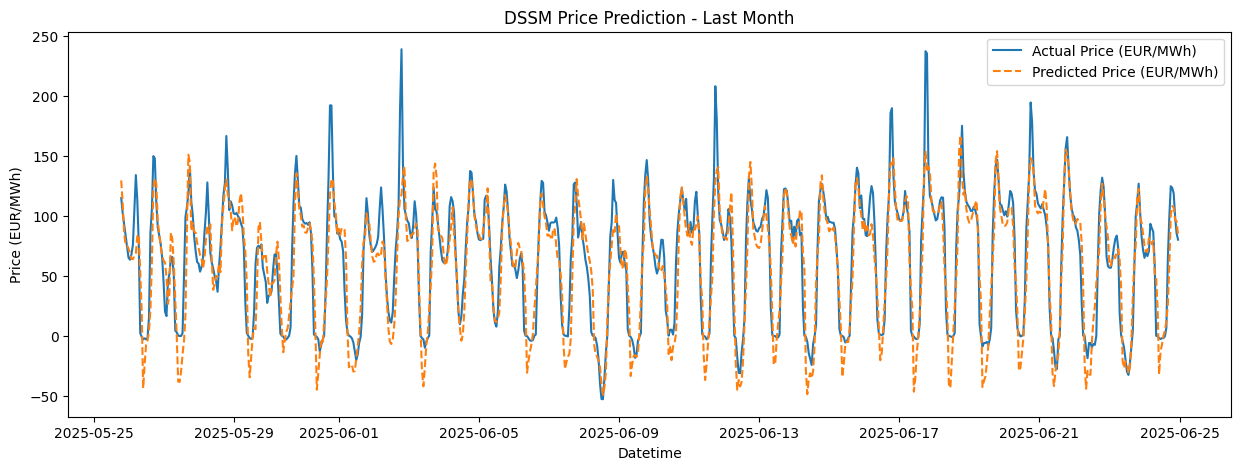

In [10]:
model.eval()
all_preds = []
all_actuals = []
with torch.no_grad():
    for x, t in val_loader:
        x, t = x.cuda(), t.cuda()
        preds = model(x)
        all_preds.append(preds.cpu().numpy())
        all_actuals.append(t.squeeze(-1).cpu().numpy())

preds_flat = np.concatenate(all_preds)
actuals_flat = np.concatenate(all_actuals)

preds_inverse = scaler_y.inverse_transform(preds_flat.reshape(-1, 1)).flatten()
actuals_inverse = scaler_y.inverse_transform(actuals_flat.reshape(-1, 1)).flatten()

# Plotting the results for the last month
val_datetimes = df["datetime"].iloc[-val_size:].reset_index(drop=True)

plt.figure(figsize=(15, 5))
plt.plot(val_datetimes, actuals_inverse, label="Actual Price (EUR/MWh)")
plt.plot(val_datetimes, preds_inverse, label="Predicted Price (EUR/MWh)", linestyle="--")
plt.title("DSSM Price Prediction - Last Month")
plt.xlabel("Datetime")
plt.ylabel("Price (EUR/MWh)")
plt.legend()
plt.show()

In [11]:
block_size  = 6
n_blocks    = 28
metrics_per_block = {"Block": [], "MSE": [], "MAE": [], "MAPE": []}

for b in range(n_blocks):
    s, e = b * block_size, (b + 1) * block_size

    # Always convert to float64 ndarray
    y_true = np.asarray(actuals_flat[s:e], dtype=np.float64)
    y_pred = np.asarray(preds_inverse[s:e],        dtype=np.float64)

    mse  = mean_squared_error(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)

    # Safe MAPE: ignore zero targets
    non_zero = y_true != 0
    mape = np.nan if not non_zero.any() else (
        np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100
    )

    metrics_per_block["Block"].append(b + 1)
    metrics_per_block["MSE"].append(mse)
    metrics_per_block["MAE"].append(mae)
    metrics_per_block["MAPE"].append(mape)

block_metrics_df = pd.DataFrame(metrics_per_block)

# Aggregate into horizon tiers (unchanged)
tier_map = {
    "Short-term (0-24h)":   range(0, 4),   # Blocks 1–4
    "Medium-term (24-72h)": range(4, 12),  # Blocks 5–12
    "Long-term (72-168h)":  range(12, 28)  # Blocks 13–28
}

tier_rows = []
for tier, idx_range in tier_map.items():
    tier_df = block_metrics_df.iloc[list(idx_range)]
    tier_rows.append({
        "Horizon": tier,
        "MSE":  tier_df["MSE"].mean(),
        "MAE":  tier_df["MAE"].mean(),
        "MAPE": tier_df["MAPE"].mean()
    })

tier_metrics_df = pd.DataFrame(tier_rows)

print("\nAggregated horizon-tier metrics")
print(tier_metrics_df.to_string(index=False, formatters={
    "MSE": "{:.3f}".format, "MAE": "{:.3f}".format, "MAPE": (lambda x: f"{x:.2f}%")
}))

last_datetime      = df["datetime"].iloc[-1]
forecast_datetimes = pd.date_range(
    start=last_datetime + pd.Timedelta(hours=1),
    periods=168,
    freq="h"
)


Aggregated horizon-tier metrics
             Horizon      MSE    MAE      MAPE
  Short-term (0-24h) 5513.620 64.513 33893.48%
Medium-term (24-72h) 5938.609 69.212 49744.97%
 Long-term (72-168h) 5322.918 61.885 25718.10%


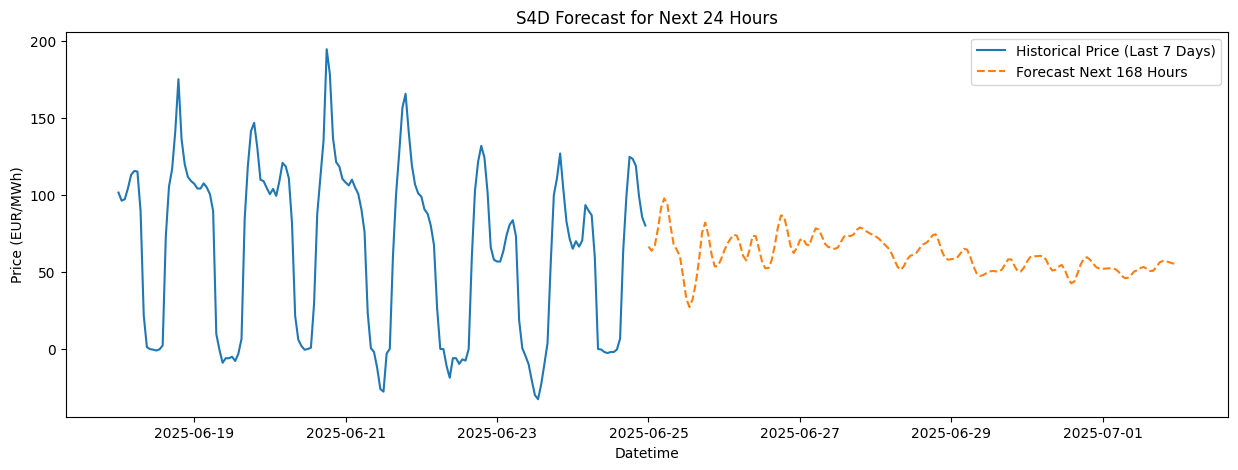

In [12]:
# Forecasting for the next 168 hours
sequence_length = 168

latest_features = df[features].iloc[-sequence_length:]
latest_scaled = scaler_x.transform(latest_features)

input_seq = torch.tensor(latest_scaled, dtype=torch.float32).unsqueeze(0).cuda() # Converting to tensor

model.eval()
forecast = []
current_seq = input_seq.clone()

with torch.no_grad():
    for _ in range(sequence_length):
        pred = model(current_seq, mode = "recurrent").item()
        forecast.append(pred)

        # Shift sequence left, drop first time step
        shifted_seq = current_seq[:, 1:, :].cpu().numpy().squeeze(0)
        next_features = latest_scaled[-1]  # Using last known features as placeholder

        # Append to shifted sequence
        new_seq = np.vstack([shifted_seq, next_features])

        current_seq = torch.tensor(new_seq, dtype=torch.float32).unsqueeze(0).cuda()

# Inverse transform the forecasted values
forecast_inverse = scaler_y.inverse_transform(np.array(forecast).reshape(-1, 1)).flatten()

# Generate forecast datetimes
last_datetime = df["datetime"].iloc[-1]
forecast_datetimes = pd.date_range(start=last_datetime + pd.Timedelta(hours=1), periods=168, freq="h")

# Plotting the forecast for the next 168 hours
plt.figure(figsize=(15, 5))
plt.plot(df["datetime"].iloc[-7*24:], df["price_EUR_MWh"].iloc[-7*24:], label="Historical Price (Last 7 Days)")
plt.plot(forecast_datetimes, forecast_inverse, label="Forecast Next 168 Hours", linestyle="--")
plt.title("S4D Forecast for Next 24 Hours")
plt.xlabel("Datetime")
plt.ylabel("Price (EUR/MWh)")
plt.legend()
plt.show()


In [13]:
# Prepare forecast DataFrame

df_forecast = pd.read_csv("../data/weather_forecast.csv", parse_dates=["datetime"])
df_forecast = df_forecast.sort_values("datetime")
df_forecast = df_forecast.dropna()

weather_features = ["temperature_2m", "wind_speed_180m", "wind_speed_120m", "direct_radiation"]
scaler_weather = StandardScaler()
scaler_weather.fit(df[weather_features])  # Fit only on weather columns
# Scale weather forecast
df_forecast[weather_features] = scaler_weather.transform(df_forecast[weather_features])


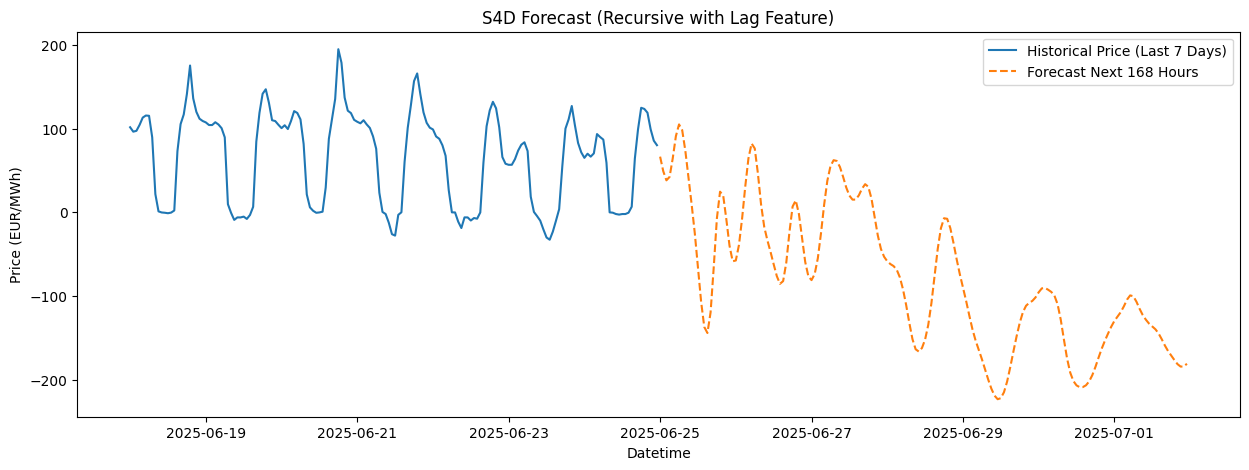

In [14]:
# Forecasting for the next 168 hours
sequence_length = 168

price_idx = features.index("price_lag1")  # the lag price feature you added and retrained on


latest_features = df[features].iloc[-sequence_length:]
latest_scaled = scaler_x.transform(latest_features)
hist_seq = latest_scaled.copy()

lag_mean  = scaler_x.mean_[price_idx]
lag_std   = scaler_x.scale_[price_idx]

days_ahead = 7
hours_per_day = 24

model.eval()
forecast = []

with torch.no_grad():
    for _ in range(days_ahead * hours_per_day):   # total hours to forecast
        x = torch.tensor(hist_seq, dtype=torch.float32).unsqueeze(0).cuda()
        pred_scaled_y = model(x, mode="recurrent").item()
        forecast.append(pred_scaled_y)

        pred_unscaled = scaler_y.inverse_transform([[pred_scaled_y]])[0, 0]
        pred_scaled_x = (pred_unscaled - lag_mean) / lag_std 

        # Prepare next input row by copying last features and overwriting lag price
        next_row = hist_seq[-1].copy()
        next_row[price_idx] = pred_scaled_x

        # Slide the window by one hour
        hist_seq = np.vstack([hist_seq[1:], next_row])


forecast_inverse = scaler_y.inverse_transform(np.array(forecast).reshape(-1, 1)).flatten()

last_datetime = df["datetime"].iloc[-1]
forecast_datetimes = pd.date_range(start=last_datetime + pd.Timedelta(hours=1), periods=days_ahead * hours_per_day, freq="h")

plt.figure(figsize=(15, 5))
plt.plot(df["datetime"].iloc[-7*24:], df["price_EUR_MWh"].iloc[-7*24:], label="Historical Price (Last 7 Days)")
plt.plot(forecast_datetimes, forecast_inverse, label=f"Forecast Next {days_ahead * hours_per_day} Hours", linestyle="--")
plt.title("S4D Forecast (Recursive with Lag Feature)")
plt.xlabel("Datetime")
plt.ylabel("Price (EUR/MWh)")
plt.legend()
plt.show()



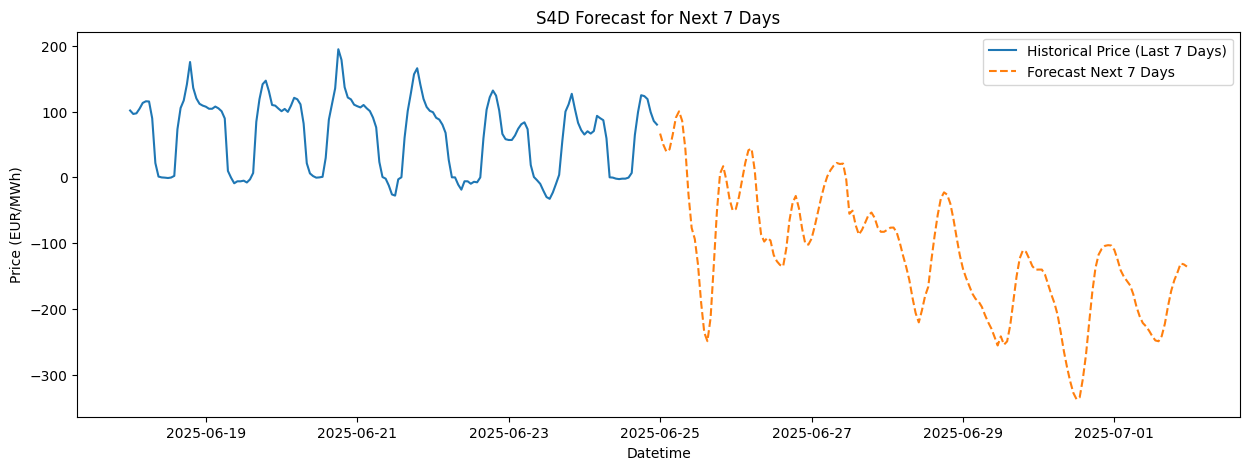

In [15]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

forecast_horizon = 168  # 7 days
sequence_length = 168

# Load weather forecast
weather_df = pd.read_csv("../data/weather_forecast.csv", parse_dates=["datetime"])
weather_df = weather_df.sort_values("datetime").reset_index(drop=True)

# Optional: Scale weather columns now if your model expects scaled weather inputs
weather_features = ["temperature_2m", "wind_speed_180m", "wind_speed_120m", "direct_radiation"]
scaler_weather = StandardScaler()
scaler_weather.fit(df[weather_features])  # Fit only on weather columns
# Scale weather forecast
weather_df[weather_features] = scaler_weather.transform(weather_df[weather_features])

# Prepare latest known features
latest_features = df[features].iloc[-sequence_length:].copy()
latest_scaled = scaler_x.transform(latest_features)

input_seq = torch.tensor(latest_scaled, dtype=torch.float32).unsqueeze(0).cuda()
current_seq = input_seq.clone()

forecast_scaled = []
forecast_unscaled = []

for i in range(forecast_horizon):
    model.eval()
    with torch.no_grad():
        pred_scaled = model(current_seq).item()  # Model predicts scaled price
        forecast_scaled.append(pred_scaled)

    pred_unscaled = scaler_y.inverse_transform(np.array([[pred_scaled]]))[0, 0]
    forecast_unscaled.append(pred_unscaled)

    shifted_seq = current_seq[:, 1:, :].squeeze(0).cpu().numpy()
    next_feature = shifted_seq[-1].copy()

    # Update lag price feature with scaled prediction (model output already scaled)
    idx_lag = features.index('price_lag1')
    next_feature[idx_lag] = pred_scaled

    # Generate new datetime
    new_datetime = df["datetime"].iloc[-1] + pd.Timedelta(hours=i + 1)

    # # Update time features
    # idx_day = features.index('is_daytime')
    # next_feature[idx_day] = 1 if 6 <= new_datetime.hour < 20 else 0

    # idx_sin = features.index('sin_hour')
    # idx_cos = features.index('cos_hour')
    # next_feature[idx_sin] = np.sin(2 * np.pi * new_datetime.hour / 24)
    # next_feature[idx_cos] = np.cos(2 * np.pi * new_datetime.hour / 24)

    # Inject weather forecast if available
    weather_row = weather_df.loc[weather_df["datetime"] == new_datetime]
    if not weather_row.empty:
        for w_feat in weather_features:
            if w_feat in features:
                idx_w = features.index(w_feat)
                next_feature[idx_w] = weather_row.iloc[0][w_feat]
    else:
        print(f"No weather forecast for {new_datetime}, keeping last known values.")

    # Build new input sequence
    new_seq = np.vstack([shifted_seq, next_feature])
    current_seq = torch.tensor(new_seq, dtype=torch.float32).unsqueeze(0).cuda()

# Create forecast datetimes
forecast_datetimes = pd.date_range(
    start=df["datetime"].iloc[-1] + pd.Timedelta(hours=1),
    periods=forecast_horizon,
    freq="h"
)



# Plot historical + forecast
plt.figure(figsize=(15, 5))
plt.plot(df["datetime"].iloc[-7*24:], df["price_EUR_MWh"].iloc[-7*24:], label="Historical Price (Last 7 Days)")
plt.plot(forecast_datetimes, forecast_unscaled, label="Forecast Next 7 Days", linestyle="--")
plt.title("S4D Forecast for Next 7 Days")
plt.xlabel("Datetime")
plt.ylabel("Price (EUR/MWh)")
plt.legend()
plt.show()
